In [479]:
# Imports
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.neighbors import KNeighborsClassifier
# # Decision Tree for comparison
from sklearn.tree import DecisionTreeClassifier
# # Used for outputting images from a file
from IPython.display import display, Image

# # If any figures change, set to true
gen_new_plot=False

# Section 2 : Scaling the Data

Scale the dataset. Additionaly, multiply the "mpg scaled" attribute by a weight of `mpg_weight` to adjust the impact for groupings of this attribute.

In [480]:
X = pd.read_csv("X.csv")
y = pd.read_csv("y.csv")

In [481]:
scaler = MinMaxScaler()
scaler.fit(X)
X_scaled = scaler.transform(X)
columns = X.columns + " scaled"
X_scaled = pd.DataFrame(X_scaled, columns=columns)

In [509]:
# adjust the 'mpg scaled' feature
display(X_scaled.head())

,year scaled,price scaled,mileage scaled,mpg scaled,engineSize scaled,Automatic scaled,Manual scaled,Semi-Auto scaled,Diesel scaled,Electric scaled,Hybrid scaled,Petrol scaled
0,0.875000,0.211101,0.089747,0.203867,0.2,1.0,0.0,0.0,0.0,0.0,0.0,1.0
1,0.916667,0.247798,0.051125,0.203867,0.2,0.0,1.0,0.0,0.0,0.0,0.0,1.0
2,0.875000,0.229450,0.070113,0.203867,0.2,0.0,1.0,0.0,0.0,0.0,0.0,1.0
3,0.958333,0.312018,0.058877,0.107735,0.3,0.0,1.0,0.0,0.0,0.0,0.0,1.0
4,0.958333,0.293670,0.008337,0.154144,0.2,1.0,0.0,0.0,0.0,0.0,0.0,1.0


In [482]:
# X_scaled.to_csv("X_scaled.csv", index=False)

---

# Section 3: Designing the KNN Model

Read the scaled data from files. Store the features and targets to variables. These variables will be used for train-test splitting.

In [483]:
# read scaled data for non-target attributes
X_scaled = pd.read_csv("X_scaled.csv")

# read the target attribute
y = pd.read_csv("y.csv").to_numpy().ravel()

### study interactions

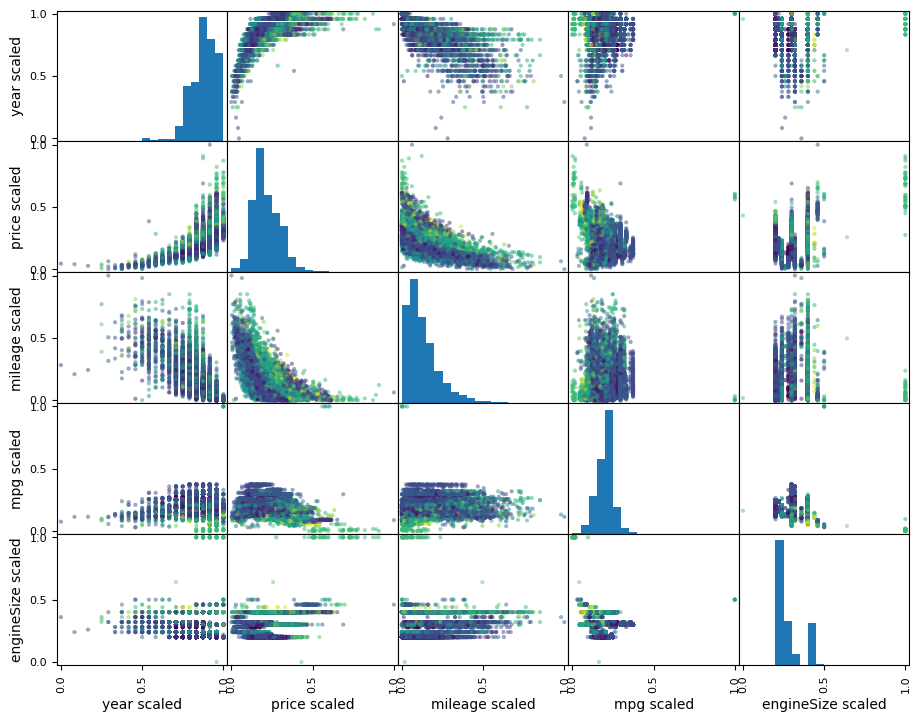

In [484]:
if (gen_new_plot):

    # labels for pairwise plots
    from sklearn.preprocessing._label import LabelEncoder
    
    pd.plotting.scatter_matrix(
        X_scaled[X_scaled.columns[[0,1,2,3,4]]],
        c=LabelEncoder().fit(y).transform(y),
        diagonal='hist',
        hist_kwds={'bins':20},
        figsize=(11, 8.5),
    )
    plt.show()
else:
    display(Image(filename=".CompiledKNN/PairPlot.png"))


Divide data into training and test sets

In [485]:
X_train_scaled, X_test_scaled, y_train, y_test = train_test_split(
    X_scaled, y,
    random_state=0
)

In [486]:
display(X_train_scaled.shape, y_train.shape)
display(X_test_scaled.shape, y_test.shape)

(13434, 12)

(13434,)

(4479, 12)

(4479,)

--- 

# Section 4: Decision Tree Comparision

Create a decision tree and a KNN from the dataset and compare accuracies of each model

In [487]:
tree = DecisionTreeClassifier(
    random_state=0
)
knn = KNeighborsClassifier()


# import the scaled data and split into training and test sets
X_train_scaled, X_test_scaled, y_train, y_test = train_test_split(
    pd.read_csv("X_scaled.csv"), 
    pd.read_csv("y.csv"), 
    random_state=0
)
y_train = np.ravel(y_train)
y_test = np.ravel(y_test)

tree.fit(X_train_scaled, y_train)
knn.fit(X_train_scaled, y_train)

# hacky way to clear the output
display() 

In [488]:
print("Accuracies on the test set")
print("tree accuracy: " + str(tree.score(X_test_scaled, y_test)))
print("knn accuracy: " + str(knn.score(X_test_scaled, y_test)))

Accuracies on the test set
tree accuracy: 0.9229738780977896
knn accuracy: 0.8374637195802634


Create a decision tree and a KNN from the secondary dataset and compare accuracies of each model

---

# Section 5: Cross Validation

Evaluate the accuracy of a 10-fold cross validation for the KNN model.

In [489]:
# features = pd.concat([X_scaled, X2_scaled], ignore_index=True, verify_integrity=True)
features = X_scaled

In [490]:
# target = pd.DataFrame(np.append(y, y2))
target = pd.DataFrame(y, columns=["model"])

In [491]:
models = target.model.unique().tolist()

In [492]:
indexes = np.empty(shape=0, dtype=np.uint16)

display(target.shape[0])

for model in models:
    mask = (target.model == model)
    if (target[mask].shape[0] <= 50):
        index = target[mask].index[:]
        print(model, "- remove", index.shape[0], "record(s)")
        indexes = np.append(indexes, index)

target = target.drop(index=indexes, axis=0)
features = features.drop(index=indexes, axis=0)

display(target.shape[0])

17913

 Tourneo Connect - remove 33 record(s)
 Fusion - remove 16 record(s)
 Ranger - remove 1 record(s)
 Streetka - remove 2 record(s)
 Escort - remove 1 record(s)
 Transit Tourneo - remove 1 record(s)


17859

In [493]:
models = target.model.unique().tolist()

In [494]:
print(models)

[' Fiesta', ' Focus', ' Puma', ' Kuga', ' EcoSport', ' C-MAX', ' Mondeo', ' Ka+', ' Tourneo Custom', ' S-MAX', ' B-MAX', ' Edge', ' Grand C-MAX', ' KA', ' Galaxy', ' Mustang', ' Grand Tourneo Connect']


In [495]:
target = target.to_numpy().ravel()

In [496]:
knn = KNeighborsClassifier()
cv = cross_val_score(knn, features, target, cv=10)

In [497]:
cv.mean()

0.8472993497510988

In [498]:
tree = DecisionTreeClassifier(
    random_state=0
)

cv_tree = cross_val_score(tree, features, target, cv=10)
cv_tree.mean()

0.9235098384258519

---


# Accuracy Assessment on individual targets

In [499]:
X_train_scaled, X_test_scaled, y_train, y_test = train_test_split(
    features, target,
    random_state=0
)

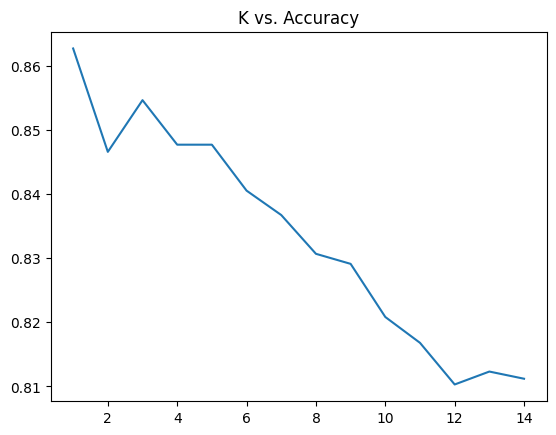

In [500]:

if (gen_new_plot):
    arr = np.array([])
    y_test = y_test.squeeze()
    for n in range(1,15):
        knn = KNeighborsClassifier(n_neighbors=n)
        knn.fit(X_train_scaled, y_train)
        y1_predict = knn.predict(X_test_scaled)
        m = np.mean(y1_predict == y_test)
        arr = np.append(arr, np.array(m))
    plt.plot(range(1, arr.size+1), arr)
    plt.title("K vs. Accuracy")
    plt.show()
else:
    filename = ".CompiledKNN/K_vs._Accuracy.png"
    display(Image(filename=filename))

In [501]:
knn = KNeighborsClassifier(n_neighbors=3)
knn.fit(X_train_scaled, y_train)
y_predict = knn.predict(X_test_scaled)
display(knn.score(X_test_scaled, y_test))

0.8546472564389698

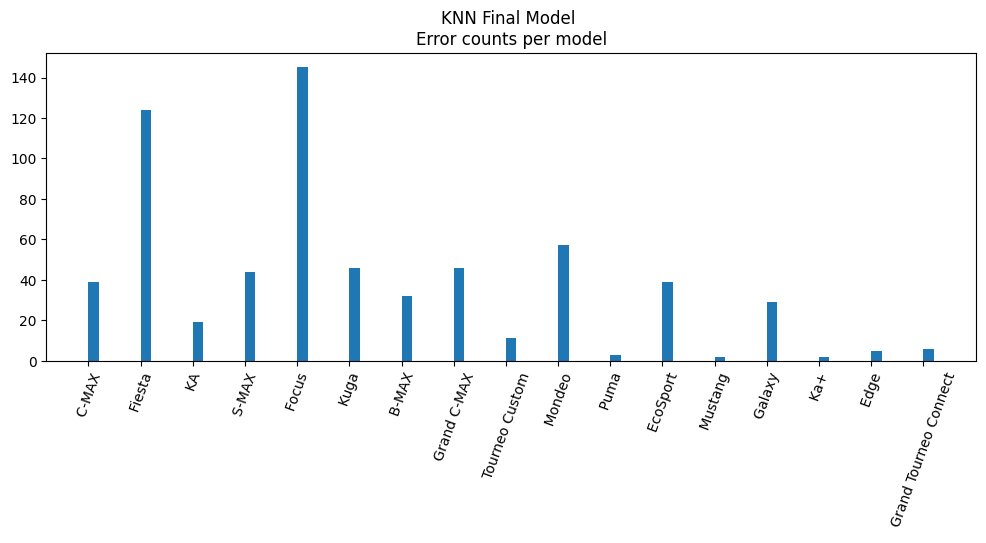

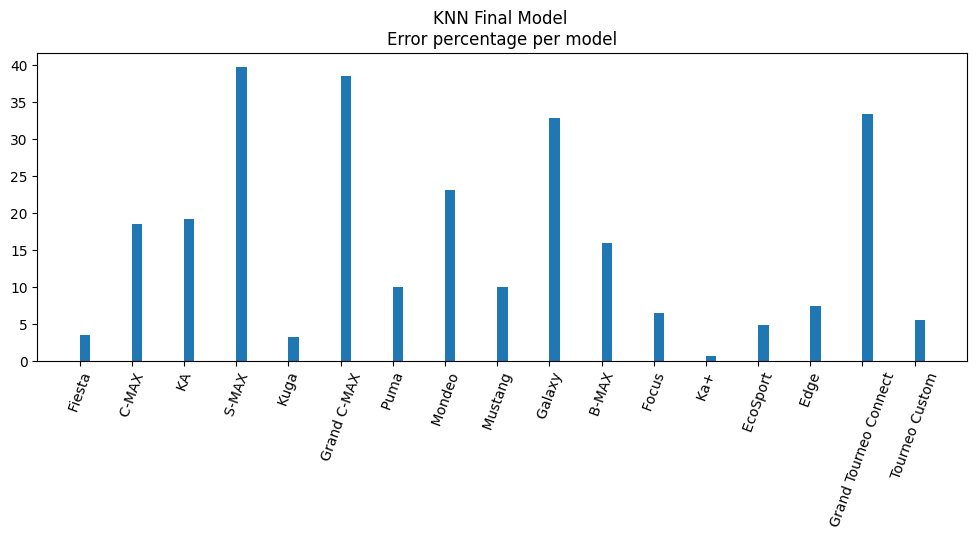

In [502]:

if (gen_new_plot):
    misclassified_y = y_test[y_test != y_predict]

    names = pd.Series(misclassified_y).unique()
    sum = 0
    error_counts = np.array([])
    name_counts = np.array([])
    for name in names:
        errors = misclassified_y[misclassified_y == name].shape[0]
        sum += errors
        error_counts = np.append(error_counts, np.array(errors))
        name_total = y_test[y_test == name].shape[0]
        name_counts = np.append(name_counts, np.array(name_total))
    display(names, misclassified_y.shape, sum)

    error_percentage = 100 * error_counts / name_counts



    # Plot misclassifications
    plt.figure(figsize=(12, 4))
    plt.bar(range(error_counts.size), height=error_counts, align='edge', width=0.2)
    plt.xticks(range(error_counts.size), names, rotation=70)
    plt.title("KNN Final Model \nError counts per model")
    plt.show()

    plt.figure(figsize=(12, 4))
    plt.bar(range(error_counts.size), height=error_percentage, align='edge', width=0.2)
    plt.xticks(range(error_counts.size), names, rotation=70)
    plt.title("KNN Final Model \nError percentage per model")
    plt.show()
else:
    # save output from the plot above as an image
    # output the image from file
    filename = ".CompiledKNN/KNN_Final_Model_Error_counts.png"
    display(Image(filename=filename))
    filename = ".CompiledKNN/KNN_Final_Model_Error_percentages.png"
    display(Image(filename=filename))





### Assess Accuracy of decision tree for comparison

In [503]:
tree = DecisionTreeClassifier()
tree.fit(X_train_scaled, y_train)
y_predict = tree.predict(X_test_scaled)
display(tree.score(X_test_scaled, y_test))

0.9260918253079508

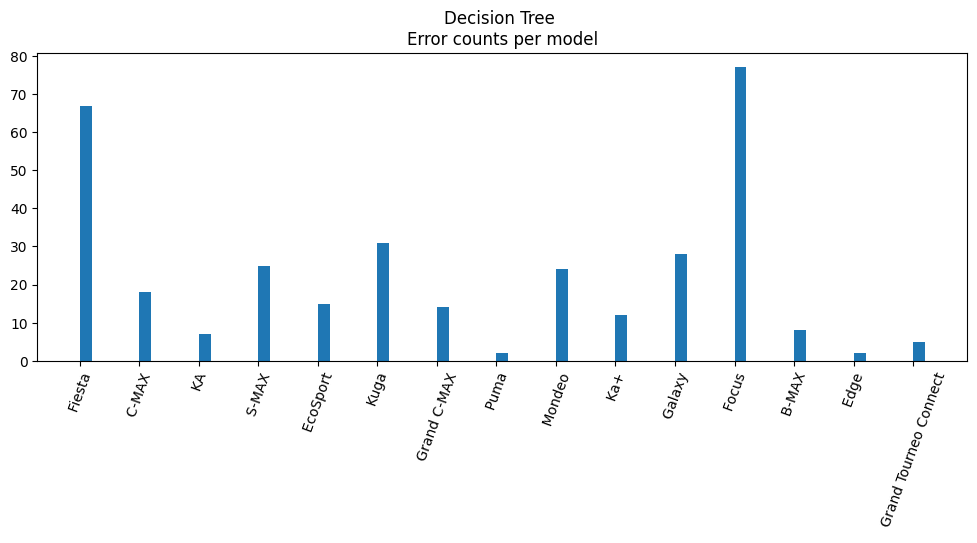

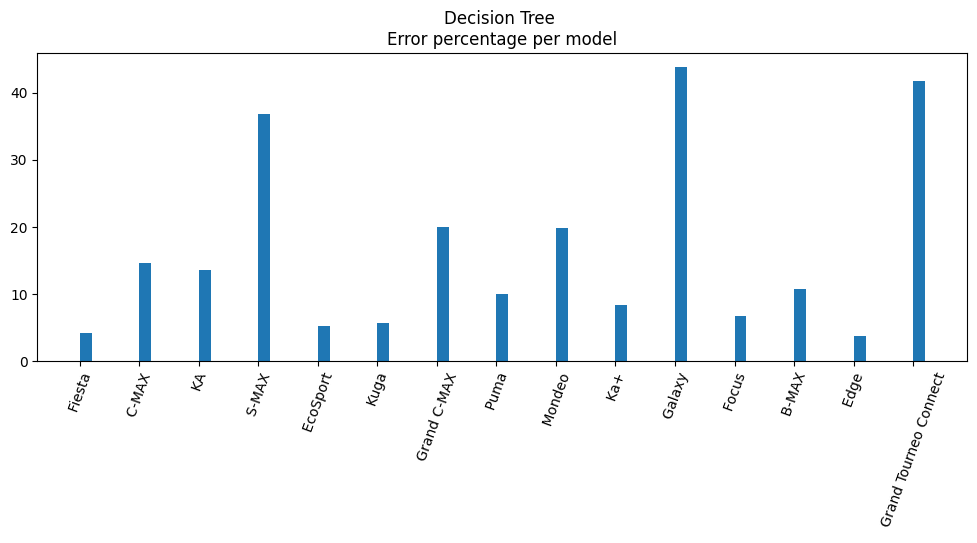

In [504]:
if (gen_new_plot):
    misclassified_y = y_test[y_test != y_predict]

    names = pd.Series(misclassified_y).unique()
    sum = 0
    error_counts = np.array([])
    name_counts = np.array([])
    for name in names:
        errors = misclassified_y[misclassified_y == name].shape[0]
        sum += errors
        error_counts = np.append(error_counts, np.array(errors))
        name_total = y_test[y_test == name].shape[0]
        name_counts = np.append(name_counts, np.array(name_total))
    display(names, misclassified_y.shape, sum)

    error_percentage = 100 * error_counts / name_counts



    # Plot misclassifications
    plt.figure(figsize=(12, 4))
    plt.bar(range(error_counts.size), height=error_counts, align='edge', width=0.2)
    plt.xticks(range(error_counts.size), names, rotation=70)
    plt.title("Decision Tree \nError counts per model")
    plt.show()

    plt.figure(figsize=(12, 4))
    plt.bar(range(error_counts.size), height=error_percentage, align='edge', width=0.2)
    plt.xticks(range(error_counts.size), names, rotation=70)
    plt.title("Decision Tree \nError percentage per model")
    plt.show()
else:
    # save output from the plot above as an image
    # output the image from file
    filename = ".CompiledKNN/Decision Tree Error counts.png"
    display(Image(filename=filename))
    filename = ".CompiledKNN/Decision Tree Error percentages.png"
    display(Image(filename=filename))

### Get accuracy assessment without scaling

In [505]:

features =  X
target = y
X_train, X_test, y_train, y_test = train_test_split(
    features, target,
    random_state=0
)

In [506]:
knn2 = KNeighborsClassifier(n_neighbors=3)
knn2.fit(X_train, y_train)
y_predict = knn2.predict(X_test)

display(knn2.score(X_test, y_test))

0.41995981245813796

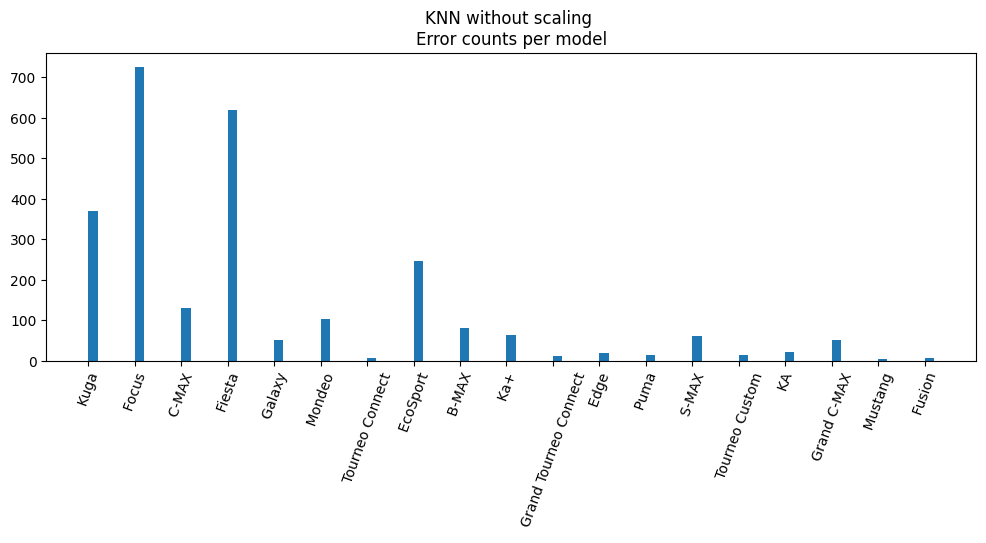

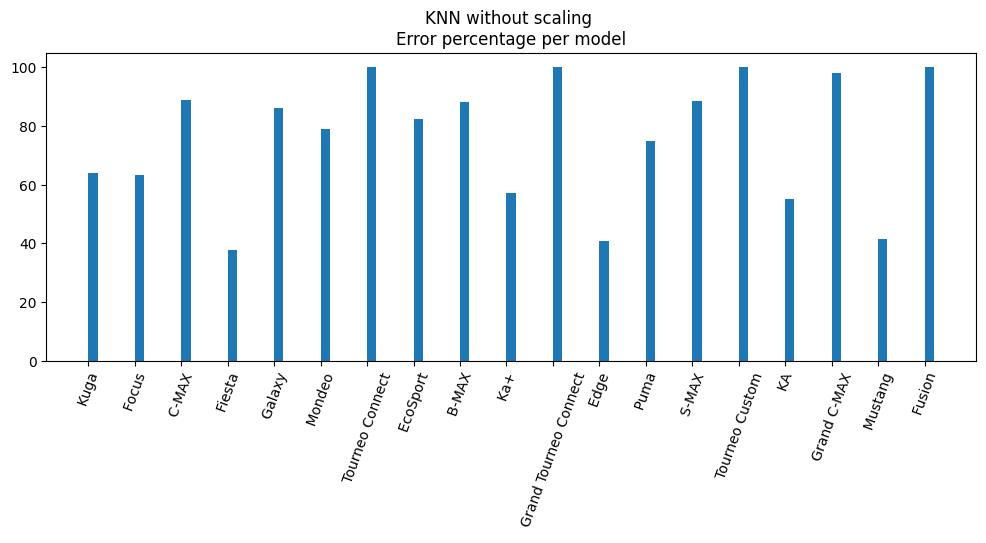

In [507]:
if (gen_new_plot):
    misclassified_y = y_test[y_test != y_predict]

    names = pd.Series(misclassified_y).unique()
    sum = 0
    error_counts = np.array([])
    name_counts = np.array([])
    for name in names:
        errors = misclassified_y[misclassified_y == name].shape[0]
        sum += errors
        error_counts = np.append(error_counts, np.array(errors))
        name_total = y_test[y_test == name].shape[0]
        name_counts = np.append(name_counts, np.array(name_total))
    display(names, misclassified_y.shape, sum)

    error_percentage = 100 * error_counts / name_counts



    # Plot misclassifications
    plt.figure(figsize=(12, 4))
    plt.bar(range(error_counts.size), height=error_counts, align='edge', width=0.2)
    plt.xticks(range(error_counts.size), names, rotation=70)
    plt.title("KNN without scaling \nError counts per model")
    plt.show()

    plt.figure(figsize=(12, 4))
    plt.bar(range(error_counts.size), height=error_percentage, align='edge', width=0.2)
    plt.xticks(range(error_counts.size), names, rotation=70)
    plt.title("KNN without scaling \nError percentage per model")
    plt.show()
else:
    # save output from the plot above as an image
    # output the image from file
    filename = ".CompiledKNN/KNN without scaling Error counts.png"
    display(Image(filename=filename))
    filename = ".CompiledKNN/KNN without scaling Error percentages.png"
    display((Image(filename=filename)))



In [508]:
display(tree.feature_importances_)
display(tree.feature_names_in_)

array([0.05724051, 0.12808442, 0.05572052, 0.48890693, 0.19449137,
       0.00266926, 0.04786197, 0.00227959, 0.00101748, 0.        ,
       0.00106646, 0.02066149])

array(['year scaled', 'price scaled', 'mileage scaled', 'mpg scaled',
       'engineSize scaled', 'Automatic scaled', 'Manual scaled',
       'Semi-Auto scaled', 'Diesel scaled', 'Electric scaled',
       'Hybrid scaled', 'Petrol scaled'], dtype=object)